In [28]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.special as sc

from astropy.io import fits

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times New Roman"],  # You can change this font if you prefer
    "axes.labelsize": 14,  # Adjust as needed
    "axes.titlesize": 16,  # Adjust as needed
    "xtick.labelsize": 14,  # Adjust as needed
    "ytick.labelsize": 14,  # Adjust as needed
    "legend.fontsize": 12,  # Adjust as needed
    "figure.figsize": (15, 8),  # Adjust as needed
    "figure.dpi": 600  # Adjust as needed
})

from tqdm import tqdm

This notebooks aims at testing if the covariance of tau statistics captures the Gaussianity of the likelihood or not following Sellentin & Heavens (2018).

In [2]:
#Load data
version = 'SP_v1.3_LFmask_8k'
tau_stats = np.empty((0, 60))

path = './data/SP_v1.3_LFmask_8k/'
for i in tqdm(range(300)):
    i_str = str(i+1).zfill(5)
    tau_stats_ = fits.getdata(path+'/tau_stats_SP_v1.3_LFmask_8k_sim_'+i_str+'.fits')
    if i==0:
        bins = tau_stats_['theta']
    tau_stats_ = np.array([tau_stats_['tau_0_p'], tau_stats_['tau_2_p'], tau_stats_['tau_5_p']]).flatten()
    tau_stats = np.vstack([tau_stats, tau_stats_])

cov_tau = np.load('data/cov_tau_'+version+'_sim.npy')

100%|██████████| 300/300 [00:02<00:00, 146.13it/s]


In [3]:
def mean_substract(data_vector):
    mean_dv = np.mean(data_vector, axis=0)
    return data_vector - mean_dv

def get_cov_submatrix(data_vector, e, f):
    cov_submatrix = np.cov(data_vector[:, (e, f)].T)
    return cov_submatrix    

def whitening_step(data_vector, e, f):
    """
    Whitening step for the data vectors between the e-th and f-th elements of the data vectors by extracting the 2x2 sub-covariance matrix.
    """
    cov_submatrix = get_cov_submatrix(data_vector, e, f)
    eigenvalues, eigenvectors = np.linalg.eig(cov_submatrix)
    whitening_transform = eigenvectors @ np.diag(eigenvalues ** (-0.5)) @ eigenvectors.T
    x_white = whitening_transform @ mean_substract(data_vector)[:, (e, f)].T
    return x_white.T

def sum_matrix(data_vector, bins):
    output = np.zeros((60, 60))

    data_vector = mean_substract(data_vector)
    for i in range(60):
        for j in range(i+1, 60):
            x_white = whitening_step(data_vector, i, j)
            s = np.sum(x_white, axis=1)
            hist_s = np.histogram(s, bins=bins, density=True)
            output[i,j] = np.sum(
                (hist_s[0] - stats.norm.pdf(0.5*(hist_s[1][:-1]+hist_s[1][1:]), loc=0, scale=2))**2
            )/bins
            output[j, i] = output[i,j]
    return output

def prod_matrix(data_vector, bins):
    output = np.zeros((60, 60))

    data_vector = mean_substract(data_vector)
    for i in range(60):
        for j in range(i+1, 60):
            x_white = whitening_step(data_vector, i, j)
            s = np.prod(x_white, axis=1)
            hist_s = np.histogram(s, bins=bins, density=True)
            x_1 = stats.norm.rvs(loc=0, scale=1, size=10000)
            x_2 = stats.norm.rvs(loc=0, scale=1, size=10000)
            hist_true = np.histogram(x_1*x_2, bins=bins, density=True)
            output[i,j] = np.sum(
                (hist_s[0] - hist_true[0])**2
            )/bins
            output[j, i] = output[i,j]
    return output

def ratio_matrix(data_vector, bins):
    output = np.zeros((60, 60))

    data_vector = mean_substract(data_vector)
    for i in range(60):
        for j in range(60):
            if i != j:
                x_white = whitening_step(data_vector, i, j)
                s = np.divide(x_white[:, 0], x_white[:, 1])
                hist_s = np.histogram(s, bins=bins, density=True)
                output[i,j] = np.sum(
                    (hist_s[0] - stats.cauchy.pdf(0.5*(hist_s[1][:-1]+hist_s[1][1:])))**2
                )/bins
    return output

def epsilon_tot_el(matrix, e):
    return np.sum(matrix[e, :])

def epsilon_tot(matrix):
    return np.array(
        [epsilon_tot_el(matrix, e) for e in range(60)]
    )

In [4]:
gaussian_tau_stats = stats.multivariate_normal(mean=np.zeros(60), cov=cov_tau).rvs(size=300)

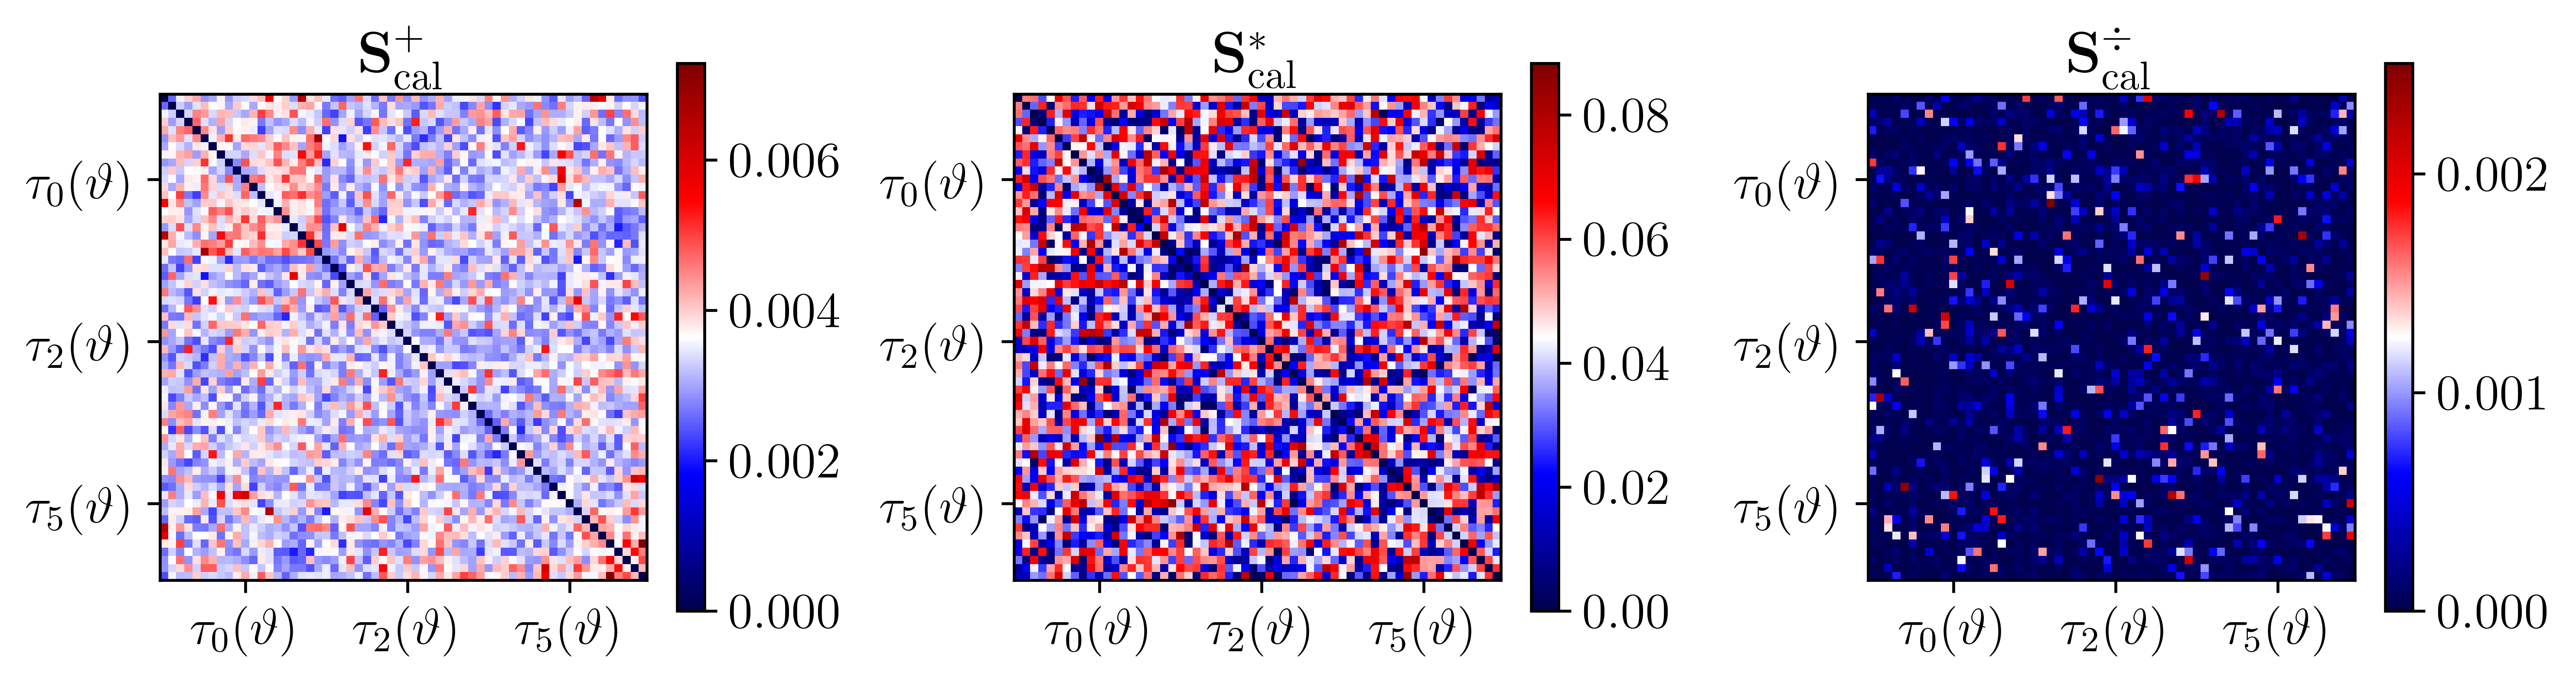

In [5]:
#Calibration of the number of bins using Gaussian samples
nbins = 35

sum_mat_gaussian = sum_matrix(gaussian_tau_stats, bins=nbins)
prod_mat_gaussian = prod_matrix(gaussian_tau_stats, bins=nbins)
ratio_mat_gaussian = ratio_matrix(gaussian_tau_stats, bins=nbins)

plt.figure(figsize=(10, 3))

plt.subplot(131)
plt.imshow(sum_mat_gaussian, cmap='seismic')
plt.gca().set_aspect('equal')
plt.xticks([10, 30, 50], labels=[r'$\tau_0(\vartheta)$', r'$\tau_2(\vartheta)$', r'$\tau_5(\vartheta)$'])
plt.yticks([10, 30, 50], labels=[r'$\tau_0(\vartheta)$', r'$\tau_2(\vartheta)$', r'$\tau_5(\vartheta)$'])
plt.title(r"$\mathbf{S}^+_{\rm cal}$")
plt.colorbar(shrink=0.8)

plt.subplot(132)
plt.imshow(prod_mat_gaussian, cmap='seismic')
plt.gca().set_aspect('equal')
plt.xticks([10, 30, 50], labels=[r'$\tau_0(\vartheta)$', r'$\tau_2(\vartheta)$', r'$\tau_5(\vartheta)$'])
plt.yticks([10, 30, 50], labels=[r'$\tau_0(\vartheta)$', r'$\tau_2(\vartheta)$', r'$\tau_5(\vartheta)$'])
plt.title(r"$\mathbf{S}^*_{\rm cal}$")
plt.colorbar(shrink=0.8)

plt.subplot(133)
plt.imshow(ratio_mat_gaussian, cmap='seismic')
plt.gca().set_aspect('equal')
plt.xticks([10, 30, 50], labels=[r'$\tau_0(\vartheta)$', r'$\tau_2(\vartheta)$', r'$\tau_5(\vartheta)$'])
plt.yticks([10, 30, 50], labels=[r'$\tau_0(\vartheta)$', r'$\tau_2(\vartheta)$', r'$\tau_5(\vartheta)$'])
plt.title(r"$\mathbf{S}^\div_{\rm cal}$")
plt.colorbar(shrink=0.8)

plt.tight_layout()
plt.show()

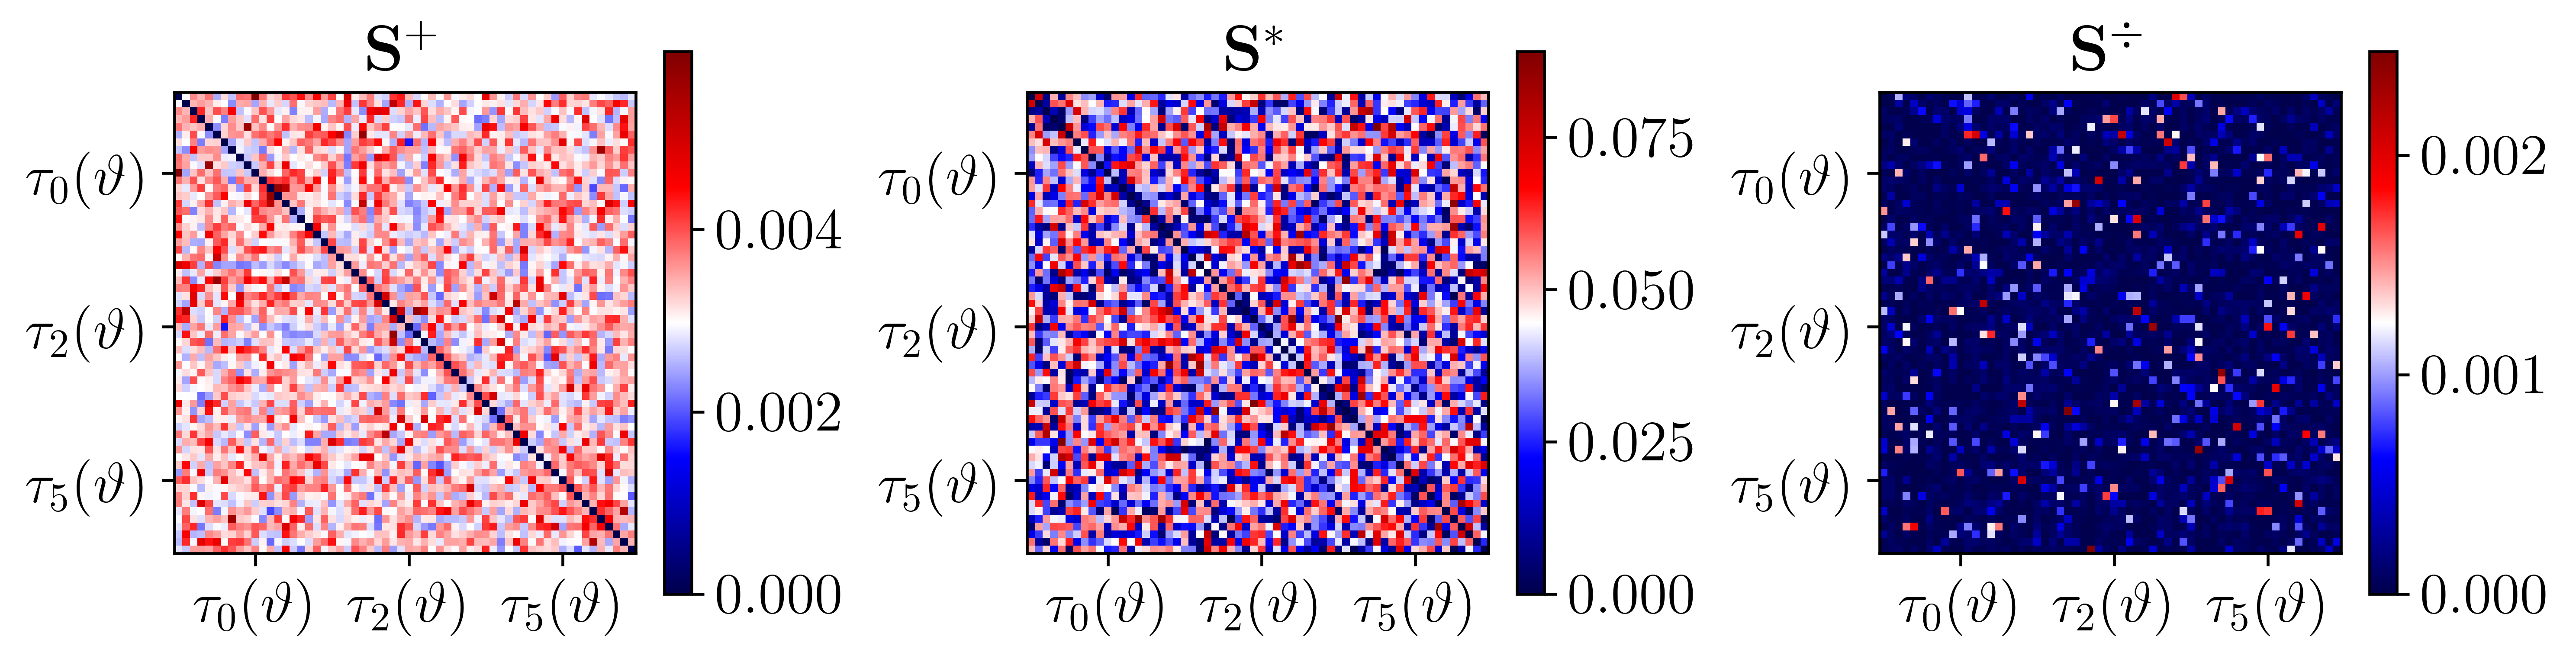

In [30]:
sum_mat = sum_matrix(tau_stats, nbins)
prod_mat = prod_matrix(tau_stats, nbins)
ratio_mat = ratio_matrix(tau_stats, nbins)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times New Roman"],  # You can change this font if you prefer
    "axes.labelsize": 16,  # Adjust as needed
    "axes.titlesize": 18,  # Adjust as needed
    "xtick.labelsize": 16,  # Adjust as needed
    "ytick.labelsize": 16,  # Adjust as needed
    "legend.fontsize": 14,  # Adjust as needed
    "figure.figsize": (15, 8),  # Adjust as needed
    "figure.dpi": 600  # Adjust as needed
})

plt.figure(figsize=(10, 3))

plt.subplot(131)
plt.imshow(sum_mat, cmap='seismic')
plt.gca().set_aspect('equal')
plt.xticks([10, 30, 50], labels=[r'$\tau_0(\vartheta)$', r'$\tau_2(\vartheta)$', r'$\tau_5(\vartheta)$'])
plt.yticks([10, 30, 50], labels=[r'$\tau_0(\vartheta)$', r'$\tau_2(\vartheta)$', r'$\tau_5(\vartheta)$'])
plt.title(r"$\mathbf{S}^+$")
plt.colorbar(shrink=0.8)

plt.subplot(132)
plt.imshow(prod_mat, cmap='seismic')
plt.gca().set_aspect('equal')
plt.xticks([10, 30, 50], labels=[r'$\tau_0(\vartheta)$', r'$\tau_2(\vartheta)$', r'$\tau_5(\vartheta)$'])
plt.yticks([10, 30, 50], labels=[r'$\tau_0(\vartheta)$', r'$\tau_2(\vartheta)$', r'$\tau_5(\vartheta)$'])
plt.title(r"$\mathbf{S}^*$")
plt.colorbar(shrink=0.8)

plt.subplot(133)
plt.imshow(ratio_mat, cmap='seismic')
plt.gca().set_aspect('equal')
plt.xticks([10, 30, 50], labels=[r'$\tau_0(\vartheta)$', r'$\tau_2(\vartheta)$', r'$\tau_5(\vartheta)$'])
plt.yticks([10, 30, 50], labels=[r'$\tau_0(\vartheta)$', r'$\tau_2(\vartheta)$', r'$\tau_5(\vartheta)$'])
plt.title(r"$\mathbf{S}^\div$")
plt.colorbar(shrink=0.8)

plt.tight_layout()
plt.savefig('Plots/transcovariances.png', dpi=600, bbox_inches='tight')
plt.show()

In [7]:
nbins = 35

epsilon_tot_sum = epsilon_tot(sum_mat_gaussian)
epsilon_tot_tau_sum = epsilon_tot(sum_mat)
epsilon_tot_prod = epsilon_tot(prod_mat_gaussian)
epsilon_tot_tau_prod = epsilon_tot(prod_mat)
epsilon_tot_ratio = epsilon_tot(ratio_mat_gaussian)
epsilon_tot_tau_ratio = epsilon_tot(ratio_mat)

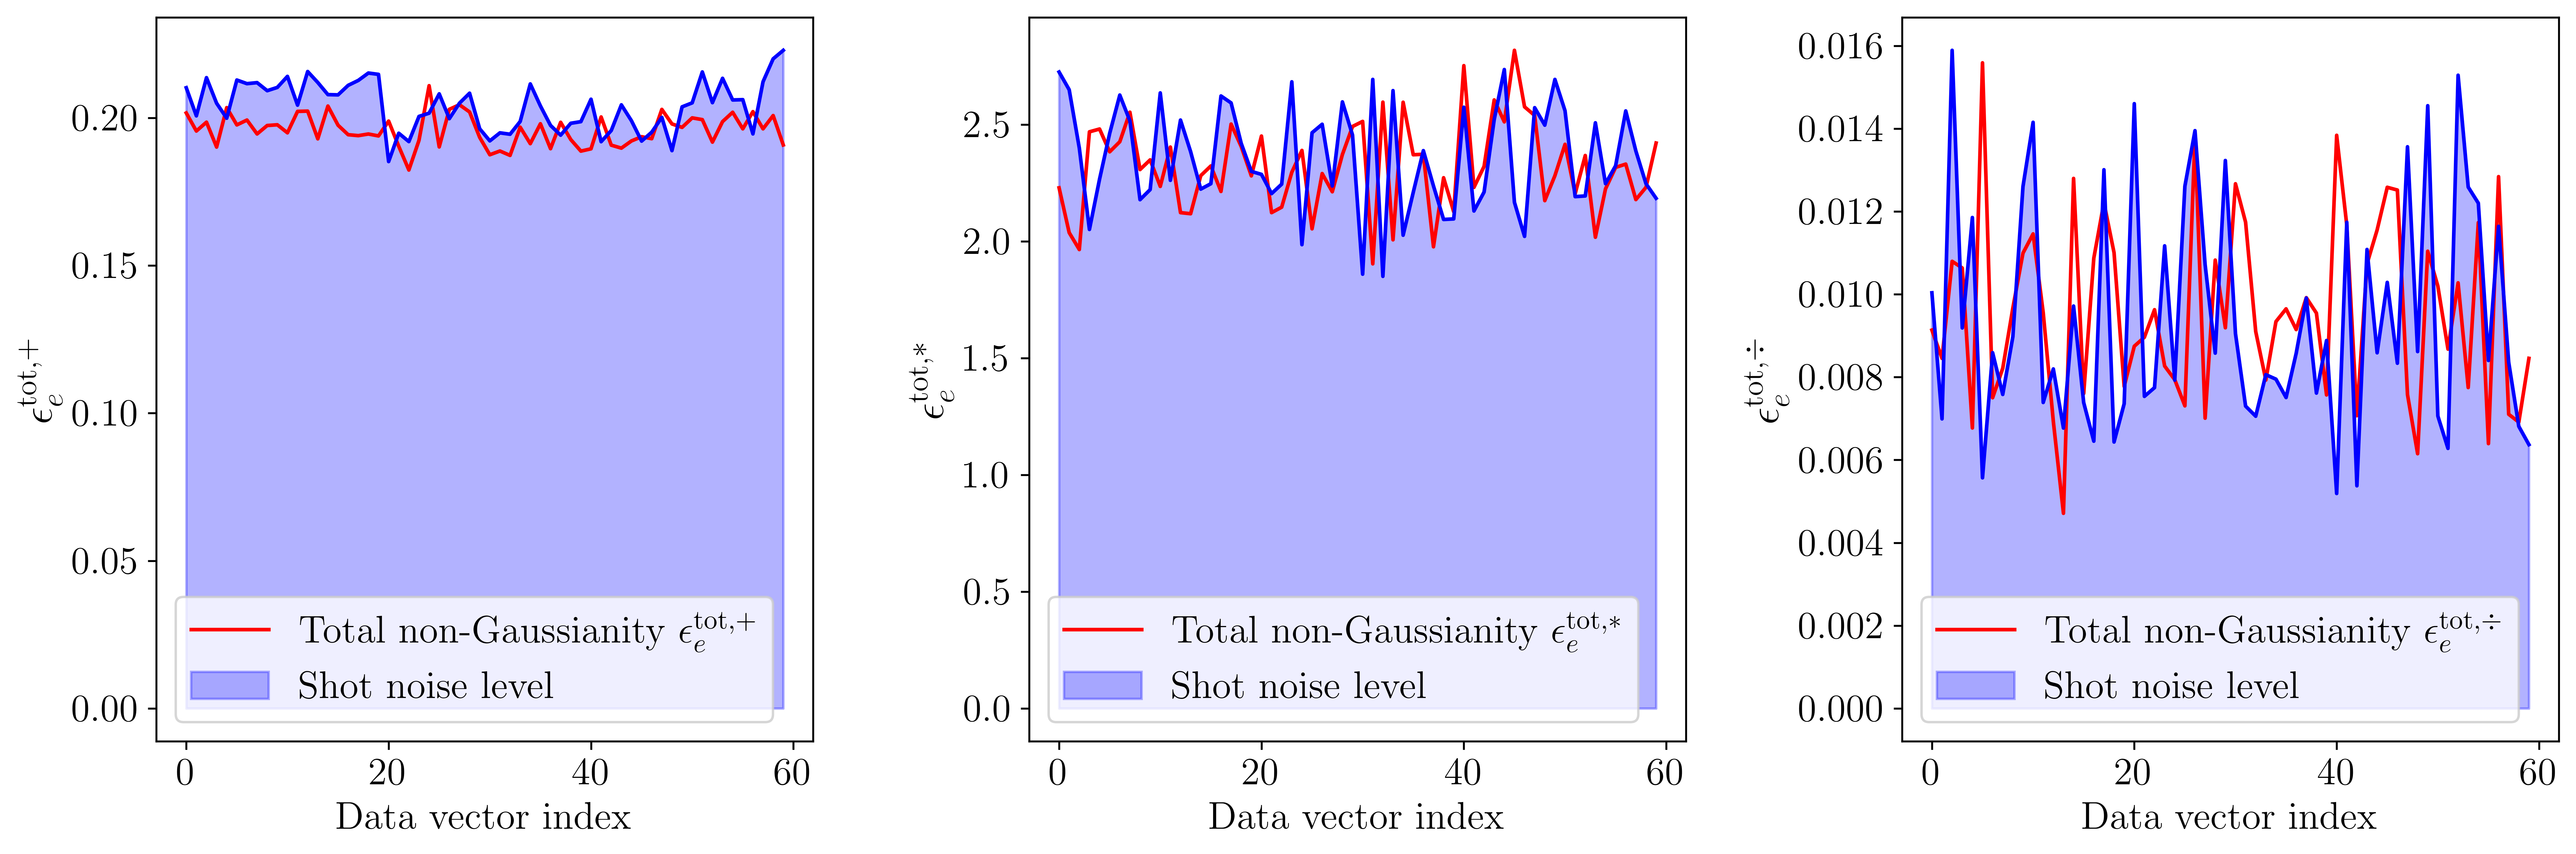

In [31]:
plt.figure(figsize=(15, 5))

plt.subplot(131)

plt.plot(epsilon_tot_tau_sum, c='r', label=r'Total non-Gaussianity $\epsilon^{\rm tot, +}_e$')
plt.plot(epsilon_tot_sum, c='b')
plt.fill_between(np.arange(60), np.zeros(60), epsilon_tot_sum, color='b', alpha=0.3, label=r'Shot noise level')
plt.ylabel(r'$\epsilon^{\rm tot, +}_e$', fontsize=18)
plt.xlabel('Data vector index')
plt.legend(fontsize=16)

plt.subplot(132)

plt.plot(epsilon_tot_tau_prod, c='r', label=r'Total non-Gaussianity $\epsilon^{\rm tot, *}_e$')
plt.plot(epsilon_tot_prod, c='b')
plt.fill_between(np.arange(60), np.zeros(60), epsilon_tot_prod, color='b', alpha=0.3, label=r'Shot noise level')
plt.ylabel(r'$\epsilon^{\rm tot, *}_e$', fontsize=18)
plt.xlabel('Data vector index')
plt.legend(fontsize=16)

plt.subplot(133)

plt.plot(epsilon_tot_tau_ratio, c='r', label=r'Total non-Gaussianity $\epsilon^{\rm tot, \div}_e$')
plt.plot(epsilon_tot_ratio, c='b')
plt.fill_between(np.arange(60), np.zeros(60), epsilon_tot_ratio, color='b', alpha=0.3, label=r'Shot noise level')
plt.ylabel(r'$\epsilon^{\rm tot, \div}_e$', fontsize=18)
plt.xlabel('Data vector index')
plt.legend(fontsize=16)

plt.tight_layout()
plt.savefig('Plots/total_non_gaussianity.png', dpi=600, bbox_inches='tight')
plt.show()